# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.321642,False,-0.637409
1,1.098294,True,4.944728
2,-0.576084,True,4.520480
3,-1.932086,True,3.990415
4,0.004718,True,5.741791
...,...,...,...
995,0.290972,True,5.455165
996,-0.828581,False,-0.378240
997,-1.269259,False,0.295400
998,1.297504,True,4.457884


<AxesSubplot:xlabel='v0'>

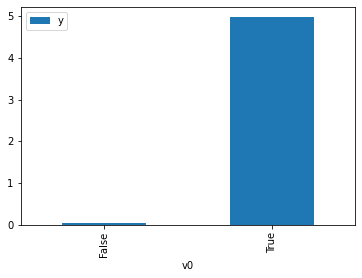

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

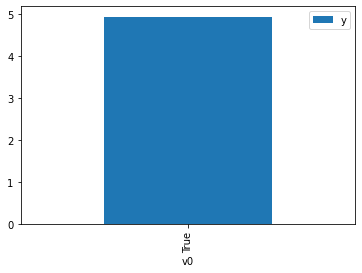

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.104658,False,-0.944485,0.605864,1.650535
1,-0.795723,False,-0.898001,0.567294,1.762756
2,-2.890913,False,-0.341378,0.794150,1.259208
3,1.545595,False,0.253375,0.281855,3.547920
4,-0.905230,False,-0.921969,0.581085,1.720919
...,...,...,...,...,...
995,-1.277213,False,-0.973239,0.626879,1.595204
996,-2.269179,False,1.835987,0.736886,1.357062
997,-0.348725,False,0.142659,0.510137,1.960258
998,0.918179,False,1.258159,0.351586,2.844252


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.560277,True,5.765811,0.605326,1.652003
1,-0.490283,True,4.496108,0.471662,2.120164
2,-0.886652,True,5.244145,0.421247,2.373907
3,0.269202,True,5.246380,0.568998,1.757476
4,-2.663472,True,4.187775,0.225664,4.431375
...,...,...,...,...,...
995,0.387711,True,3.497712,0.583902,1.712617
996,1.607041,True,5.775217,0.724507,1.380249
997,-1.494715,True,4.988505,0.347308,2.879288
998,0.434750,True,5.597173,0.589777,1.695557


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.922
Model:                            OLS   Adj. R-squared (uncentered):              0.922
Method:                 Least Squares   F-statistic:                              5903.
Date:                Fri, 29 Jul 2022   Prob (F-statistic):                        0.00
Time:                        15:40:45   Log-Likelihood:                         -1402.3
No. Observations:                1000   AIC:                                      2809.
Df Residuals:                     998   BIC:                                      2818.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1301      0.028      4.732      0.000       0.076       0.184
x2             5.0336      0.047    107.220      0.000       4.942       5.126
==============================================================================
Omnibus:                        0.071   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.965   Jarque-Bera (JB):                0.082
Skew:                           0.020   Prob(JB):                        0.960
Kurtosis:                       2.983   Cond. No.                         1.78
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""